# Connect to Google Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder
# os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
os.chdir('/content/gdrive/My Drive/detectron')
!ls

Mounted at /content/gdrive
coco_test  coco_train  coco_validate  hha  models  output  test.png


# BilinearUpSampling2D Layer
Since tensorflow does not have BilinearUpSampling2D layer for us to use, we have to implement it.

In [ ]:
from tensorflow.keras.layers import Layer, InputSpec
import keras.utils.conv_utils as conv_utils
import tensorflow as tf
import keras.backend as K

def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format
    

class BilinearUpSampling2D(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(BilinearUpSampling2D, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    input_shape[1],
                    height,
                    width)
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],
                    height,
                    width,
                    input_shape[3])

    def call(self, inputs):
        input_shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
        
        return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR)

    def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Custom Loss Function for depth model

In [ ]:
import keras.backend as K
import tensorflow as tf

def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0/10.0):
    
    # Point-wise depth
    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

# Helper Functions

In [ ]:
import numpy as np
from PIL import Image

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

def load_images(image_files):
    loaded_images = []
    images_original_res = []
    for file in image_files:
        img = Image.open(file)
        images_original_res.append(img.size)
        resize_img = img.resize((640, 480))
        x = np.clip(np.asarray(resize_img, dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0), images_original_res

def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)

def display_images(outputs, inputs=None, gt=None, is_colormap=True, is_rescale=True):
    import matplotlib.pyplot as plt
    import skimage
    from skimage.transform import resize

    plasma = plt.get_cmap('plasma')

    shape = (outputs[0].shape[0], outputs[0].shape[1], 3)
    
    all_images = []

    for i in range(outputs.shape[0]):
        imgs = []
        
        if isinstance(inputs, (list, tuple, np.ndarray)):
            x = to_multichannel(inputs[i])
            x = resize(x, shape, preserve_range=True, mode='reflect', anti_aliasing=True )
            imgs.append(x)

        if isinstance(gt, (list, tuple, np.ndarray)):
            x = to_multichannel(gt[i])
            x = resize(x, shape, preserve_range=True, mode='reflect', anti_aliasing=True )
            imgs.append(x)

        if is_colormap:
            rescaled = outputs[i][:,:,0]
            if is_rescale:
                rescaled = rescaled - np.min(rescaled)
                rescaled = rescaled / np.max(rescaled)
            imgs.append(plasma(rescaled)[:,:,:3])
        else:
            imgs.append(to_multichannel(outputs[i]))

        img_set = np.hstack(imgs)
        all_images.append(img_set)

    all_images = np.stack(all_images)
    
    return skimage.util.montage(all_images, multichannel=True, fill=(0,0,0))

In [ ]:
def getImagesFromDirectories(path):
  directory_contents = os.listdir(path)

  ret = []
  for item in directory_contents:
    filename = path + "/" + item

    if not os.path.isdir(filename):
      ret.append(filename)
    
  return ret

In [ ]:
def NormalizeDepth(depth):
  max = -1000
  min = 1000

  for row in depth:
    for col in row:
      if col > max:
        max = col

      if col < min:
        min = col

  range = max - min

  for idx, x in np.ndenumerate(depth):
    depth[idx] = (max - depth[idx]) / range * 255

#Load Pre-Trained Models
kitti pretrained model downloaded from: https://drive.google.com/file/d/19flUnbJ_6q2xtjuUQvjt1Y1cJRwOr-XY/view?usp=sharing

nyu pretrained model downloaded from: https://drive.google.com/file/d/19dfvGvDfCRYaqxVKypp1fRHwK7XtSjVu/view?usp=sharing

In [ ]:
from tensorflow.keras.models import load_model

custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}
#model = load_model("models/kitti.h5", custom_objects=custom_objects, compile=False)
model = load_model("models/kitti.h5", custom_objects=custom_objects, compile=False)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, None, None,   0          ['input_1[0][0]']                
 D)                             3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_1[0][0]']       
                                64)                                                         

# Get images
Get images from a directory for depth prediction

In [ ]:
#inputs = load_images(["coco_test/data/s0cm 253.jpg", "coco_test/data/s0cm2 023.jpg", "coco_test/data/Test_4 070.jpg", "coco_test/data/Test_4 238.jpg", "coco_test/data/alu_batch_1_255.jpg", "coco_test/data/alu_batch_1_272.jpg", "coco_test/data/grass_batch_1_174.jpg", "coco_test/data/grass_batch_1_221.jpg", "coco_test/data/acrylic_batch_1_151.jpg", "coco_test/data/acrylic_batch_1_116.jpg"])
#inputs = load_images(["models/119_image.png"])

In [ ]:
import math

SRC_PATH = "coco_test/data"
DST_PATH = "coco_test/kitti-depth"
images_path = getImagesFromDirectories(SRC_PATH)

batch_num = 64
size = len(images_path)
num = math.ceil(size/batch_num)

#Predict depth by batches

In [ ]:
import cv2

In [ ]:
for i in range(num):
  if i == num -1:
    cur_imges_path = images_path[i*batch_num:]
  else:
    cur_imges_path = images_path[i*batch_num:(i+1)*batch_num]

  inputs, original_res = load_images(cur_imges_path)
  outputs = predict(model, inputs)

  print(len(outputs))
  print(outputs.shape)
  print(outputs[0].shape)
  print(outputs[0,:,:,0].shape)
  print(original_res[0])

  for i in range(len(outputs)):
    NormalizeDepth(outputs[i,:,:,0])

    dimg = cv2.cvtColor(outputs[i,:,:,0], cv2.COLOR_GRAY2RGB)
    dimg = cv2.resize(dimg, original_res[i], interpolation = cv2.INTER_AREA)
    print(dimg.shape)
    print(DST_PATH + '/' + os.path.basename(cur_imges_path[i]))
    cv2.imwrite(DST_PATH + '/' + os.path.basename(cur_imges_path[i]), dimg)
    
    #depth = Image.fromarray(outputs[i,:,:,0], 'L')
    #print(DST_PATH + '/' + os.path.basename(cur_imges_path[i]))
    #depth.save(DST_PATH + '/' + os.path.basename(cur_imges_path[i]))

64
(64, 240, 320, 1)
(240, 320, 1)
(240, 320)
(3840, 2160)
(2160, 3840, 3)
coco_test/kitti-depth/grass_batch_1_179.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_23 092.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_16 048.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_1 037.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_23 126.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_23 210.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_25 256.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_5 090.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_17 120.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_14 257.jpg
(2160, 3840, 3)
coco_test/kitti-depth/grass_batch_1_115.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_21 103.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_2 258.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_20 082.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_23 145.jpg
(464, 848, 3)
coco_test/kitti-depth/Test_15 234.jpg
(2160, 3840, 3)
coco_test/kitti-depth/acrylic_batch_1_31.jpg
(464, 848, 3)
coco_test/kitti-depth

#Visualise

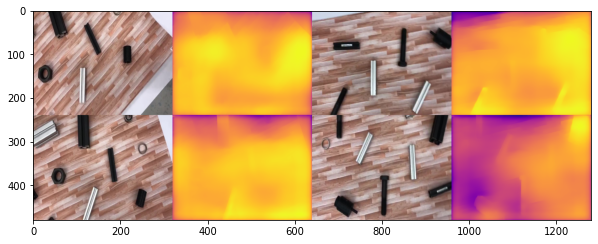

In [ ]:
from matplotlib import pyplot as plt

viz = display_images(outputs[:4].copy(), inputs[:4].copy())
plt.figure(figsize=(10,5))
plt.imshow(viz)
plt.savefig('test.png')
plt.show()